<center>
<h1>188.980 Advanced Information Retrieval</h1>
<h2>Assignment 2 - Music IR</h2>
</center>

**Group Number:**

* **Group members:**
 * **Full Name:** Borna Feldšar
   * *Matrikelnummer:* 1638974
   * *Studienkennzahl:*
 * **Full Name:** Krešimir Kasal
   * *Matrikelnummer:* 00026127
   * *Studienkennzahl:*

# Introduction

The aim of this exercise is to get insights into music information retrieval practices. You will follow a content based approach which is based on the idea that the semantically relevant information is provided in the audio itself. Thus the aim is to identify and extract this information in a meaningful representation. 

In [1]:
#%load_ext autoreload
#%autoreload 2

# plotting functions
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import os              # access to operating system functions
import glob            # reg-ex based file-iterator

# scientific computing
import numpy as np     # numerical computing
import pandas as pd    # powerful data processing library

# audio feature extraction
import librosa
from rp_extract import rp_extract

# machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC

from utility_functions import show_classification_results, plot_confusion_matrix, show_query_results

# misc
import itertools
import progressbar

# Prepare your data

First, please download the specified data-set, extract it locally to your hardisk and specify the full-path to the extracted directory to the *AUDIO_COLLECTION_PATH* variable below

In [2]:
AUDIO_COLLECTION_PATH = "genres"

**Prepare file-lists and ground-truth labels**

Define the collection of files to process and the corresponding class labels which is also known as *ground truth*.

* create a list of filenames and a list of corresponding labels
  * e.g. use [glob](https://docs.python.org/2/library/glob.html) to iterate over the class directories in the music collection
  * use the names of the subdirectories as label names
  * iterate through all class directories and get all filenames with the extension '.mp3'
  * store the filename and its corresponding label in the two lists *filenames* and *labels*
  
Take care that both lists are synchronously aligned and that each label corresponds to the right filename.

In [3]:
# fill these lists with values
filenames = []
labels    = []
# add your code here
import fnmatch
import os

for root, dirnames, file_names in os.walk(AUDIO_COLLECTION_PATH):
    for filename in fnmatch.filter(file_names, '*.mp3'):
        genre = filename.split(".")[0]
        labels.append(genre)
        filenames.append(os.path.join(AUDIO_COLLECTION_PATH,genre,filename))


# Music Feature Extraction

*Feature extraction* is a crucial part of content-based approaches. The goal is to transform and reduce the information provided by the digital audio signal into a set of semantically descriptive numbers. A typical CD quality mainstream radio track has an average length of three minutes. This means, that song is digitally described in Pulse-code Modulation (PCM) by 15.9 million numbers (3 [minutes] x 60 [seconds] x 2 [stereo channels] x 44100 [sampling rate]). Using CD-quality 16bit encoding this information requires 30.3MB of memory. Besides music specific reasons, the computational obstacles concerned with processing of huge music collections make raw audio processing a suboptimal solution. Feature design and implementation tries to overcome technological obstacles of digital audio and to extract essential music properties that can be used to analyze, compare or classify music. 

You will use the common music features are descriptors for timbre \cite{logan2000mel}, rhythm \cite{lidy10_ethnic} or general spectral properties \cite{tzanetakis2000marsyas,lartillot2007matlab}.

In [4]:
# Fill these lists with values
audio_features = {}
audio_features["mfcc"]   = []
audio_features["chroma"] = []
audio_features["ssd"]    = []
audio_features["rp"]     = []



* iterate over all audio files
    1. load audio data using the [librosa.core.load](http://librosa.github.io/librosa/generated/librosa.core.load.html) function. The feature extractors you will use expect a mono signal as input, so take care to appropriately load or convert the audio data.<br><br>
    2. extract music features<br><br>
        2.1. [Mel-frequency cepstral coefficients (MFCC)](http://librosa.github.io/librosa/generated/librosa.feature.mfcc.html) (librosa): extract 12 coefficients using a FFT-window size of 1024 samples with 50% overlap (this corresponds to a hop-length of 512 samples). To correctly calculate the coefficients the samplerate of the audio file has to be provided.<br>
         2.2. [Pitch-classes / Chroma](http://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html) (librosa): extract the chroma features using a FFT-window size of 1024 samples with 50% overlap, similar to the MFCCs. Also supply the correct samplerate.<br>
         2.3. The features extracted using the libros-library are provided on a frame-level. They are calculated for each FFT-window and thus the results are lists of feature vectors. The machine learning algorithms you will be using expect a single-vector per instance. Thus, the extracted feature vectors need to be aggregated into a single-vector representation. You will be using the simple approach of just calculating their mean and standard-deviations. Perform the following operations for the *MFCC* and *chroma* features:
      * use the numpy functions *mean* and *std* to calculate the statistical moments of the extracted features along the appropriate axis.
      * use the numpy function *concatenate* to concatenate the statistical moments into a single vector
  
    2.4. *Statistical Spectrum Descriptors* and *Rhythm Patterns*: use the following code to extract the psychoaccoustic feature-sets. The function returns a dictionary of extracted features. The Statistical Spectrum Descriptors are stored using the key 'ssd' and the Rhythm Patterns using the key 'rp'. The features are already single vectors so no post-processing is required.

                rp_features = rp_extract(wave_data, 
                                         samplerate, 
                                         extract_ssd = True, 
                                         extract_rp  = True,
                                         skip_leadin_fadeout = 0, 
                                         verbose     = False)

    3. append the extracted features to the dictionary embedded lists which are provided above.<br><br>
    4. finally iterate over the dictionary keys and convert the lists of extracted feature-vectors into feature-spaces by converting them into numpy arrays using the numpy *asarray* function.

  
The feature extraction will take about 30 minutes

In [5]:
# progressbar visualization widget to estimate processing time
pbar = progressbar.ProgressBar()

# iterate over all files of the collection
for audio_filename in pbar(filenames):
    
    # 1. load audio
    y,sr = librosa.load(audio_filename)
    # 2. extract features
    # - 2.1. mfcc
    mfcc = librosa.feature.mfcc(y=y,sr=sr, n_fft=1024, hop_length=512, n_mfcc=12)
    # - 2.2. chroma
    chroma = librosa.feature.chroma_stft(y=y,sr=sr, n_fft=1024, hop_length=512)
    # -- 2.3. aggregate frame based mfcc and chroma vectors into single feature vectors
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    mfcc_sm = np.concatenate((mfcc_mean, mfcc_std))

    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    chroma_sm = np.concatenate((chroma_mean, chroma_std))
    
    # - 2.4. ssd, rp
    rp_features = rp_extract(y, 
                              sr, 
                              extract_ssd = True, 
                              extract_rp  = True,
                              skip_leadin_fadeout = 0, 
                              verbose     = False)
    # 3. append to provided lists
    audio_features["mfcc"].append(mfcc_sm)
    audio_features["chroma"].append(chroma_sm)
    audio_features["ssd"].append(rp_features["ssd"])
    audio_features["rp"].append(rp_features["rp"])
# 4. convert lists of vectors to numpy arrays
audio_features["mfcc"] = np.asarray(audio_features["mfcc"])
audio_features["chroma"] = np.asarray(audio_features["chroma"])
audio_features["ssd"]    = np.asarray(audio_features["ssd"])
audio_features["rp"] = np.asarray(audio_features["rp"])

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\User\AppData\Roaming\Python\Python27\site-packages\librosa\util\utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
100% (1000 of 1000) |####################| Elapsed Time: 0:10:25 Time:  0:10:25


# Music Classification

Music Genre Recognition is a well researched Music Information Retrieval task. As for many other audio-based MIR tasks the algorithmic design consists of two parts. First, audio-content descriptors are extracted from the audio signal. In a second step these features are used to train machine learning based models, using popular supervised classifiers including k-nearest neighbors (k-NN), Gaussian mixture models (GMM) or Support Vector Machines (SVM).

## Data-preprocessing

The ground-truth labels are provided using their class names, in our case they are names of music genres, and thus are string values. The applied machine-learning algorithms expect numerical class labels. Thus, you are required to pre-process your data:

 * use sklearn's *LabelEncoder* to convert string- into numeric-labels
 * fit the encoder on the provided genre labels
 * create a list called *encoded_labels* using the *transform* method of the encoder

In [6]:
# add your code here
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

## Classification Experiments

Iterate over all feature-sets. For each previously extracted feature perform the following steps:

1. A common way to evaluate the performance of a machine learning approach is to perform a cross-validation. For this exercise you will be using a stratified K-Fold cross-validation. A K-Fold cross-validation splits the data-set into K equally-sized parts and uses K-1 parts to train the classifier and the remaining part to test it. The stratification asserts that the frequency distribution of the class labels within the folds corresponds to the original distribution of the ground-truth assignment. As a first step create a shuffled *StratifiedKFold* cross-validation object which generated 10 *splits* (10-fold cross-validation).<br><br>

2. For each train/test-split apply the following commands:

    2.1. Pre-process the feature-space: audio features are usually abstract content descriptors and have varying value ranges. Many machine learning algorithms expect all features to have the same value ranges. Thus, varying ranges will have a bias towards features with high value ranges. You will use Zero-Mean Unit-Variance Normalization - also referred to as Z-Score normalization or standardization, which subtracts the mean value from each feature and divides it by its variance. An important fact to note here, is that the parameters of the scaler are part of the trained classification model. They have to be assessed from the training-split, because the test-split is supposed to be unseen data. Use the sklearn *StandardScaler* and process the feature-data similar to the *LabelEncoder* by fitting the scaler using only the training-instances. After fitting the scaler transform the feature vectors of the training-split (but do not overwrite the original features!).<br>
    2.2. You will use the Support Vector Machine (SVM) classifier to train a model for automatic genre prediction. The sklearn recently made some efforts to standardize their APIs. Thus, also the SVM classifier adheres to the same pattern. First, create a *LinearSVC* classifier using its default parameters. Then, train the SVM using the *fit* method by supplying the train-split of the feature vecotrs and the ground-truth labels.<br>
    2.3. similar to 2.1. standardize the test-split using the already fitted scaler.<br>
    2.4. use the fitted SVM to predict the scaled test-split feature vectors using its *predict* method.<br>
    2.5. for each fold, store the true and predicted numeric labels.<br><br>
    
3. for each feature-set, store the true and predicted labels of the evaluation back to the provided dictionary.


In [18]:
# fill this dictionary with values
classification_results = {}
skf = StratifiedKFold(n_splits=10)

pbar = progressbar.ProgressBar()

for feature_name in pbar(audio_features.keys()):
    X,y = audio_features[feature_name], encoded_labels
    # 1. crossvalidation
    splits = skf.split(X,y)
    # 2. run cross-validation
    for train_index, test_index in splits:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # --- TRAIN ---
        scaler = StandardScaler()
        # 2.1. fit scaler
        # scale training-partition of features
        X_train = scaler.fit_transform(X_train)
        # 2.2. create classifier
        clf = LinearSVC()
        # fit classifier with scaled training-set
        clf.fit(X_train, y_train)
        # --- TEST ---
        
        # 2.3. scale test-partition of features
        X_test = scaler.transform(X_test) 
        # 2.4. use fitted classifier to predict labels of test-partition
        y_pred = clf.predict(X_test)
        # 2.5. store the true and predicted labels
        y_true = y_test
        
    # 3. store the classification results back to the dictionary
    classification_results[feature_name] = [y_true, y_pred]
    

100% |########################################################################|


**Plot the classification result table**

If you have supplied the results in the requested format, you should be able to use our provided function to plot the classification results-table.

In [19]:
show_classification_results(classification_results)

Featureset,Accuracy,Precision,Recall,F1-Score
ssd,0.68,0.672987,0.68,0.671100
mfcc,0.57,0.518283,0.57,0.531775
rp,0.56,0.582751,0.56,0.537314
chroma,0.40,0.434031,0.40,0.392123


## Feature-set combinations

Music is a complex concept which cannot be described easily by a single property. Music is not just rhythm or a certain timbre/sound. It is more a mixture of all of it. This also applies to music features. Different combinations of features perform better than others, but there is no rule of thumbs which ones. This has to be evaluated according the underlying dataset, the applied classifier, the normalization method, etc. All these parameters affect the performance of the classification model.

For this exercise, extend the previously developed classification approach by a feature combination component. Because the dataset is small, it is feasable to evaluate all possible feature-set combinations. Execute to the following cell to calculate all combinations:

In [7]:
combinations = []

for i in range(1,len(audio_features.keys())):
    combinations.extend(itertools.combinations(audio_features.keys(), i))

Combining features is also referred to as fusion and two common approaches, early fusion and late fusion, exist. You will be using an early fusion approach to extend the classification experiment. To do so, either copy and paste the code of the evaluation-loop into a new cell, or adapt the code of the existing cell:

* in the for loop, change the iterable from *audio_features.keys()* to *combinations*. You are also adviced to change the variable name *feature_name* to reflect the circumstance that the variable contains now a list of feature names.
* implement the early fusion approach. This is accomplished by appending one feature vector to the other to create a combined feature vector. This can be solved by combining the feature-spaces. Use the numpy function *concatenate* to concatenate the feature combinations along feature axis. This can be done before the cross-validation loop or within. 
* be sure to reset the *classification_results* dictionary before running the evaluation again.

In [8]:
# fill this dictionary with values
classification_results_fused = {}
skf = StratifiedKFold(n_splits=10)

pbar = progressbar.ProgressBar()
for feature_names in pbar(combinations):
    x = []
    for feature_name in feature_names:
        x.append(audio_features[feature_name])
    X,y  = np.concatenate(x, axis=1), encoded_labels   
    # 1. crossvalidation
    splits = skf.split(X,y)
    # 2. run cross-validation
    for train_index, test_index in splits:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # --- TRAIN ---
        scaler = StandardScaler()
        # 2.1. fit scaler
        # scale training-partition of features
        X_train = scaler.fit_transform(X_train)
        # 2.2. create classifier
        clf = LinearSVC()
        # fit classifier with scaled training-set
        clf.fit(X_train, y_train)
        # --- TEST ---
        
        # 2.3. scale test-partition of features
        X_test = scaler.transform(X_test) 
        # 2.4. use fitted classifier to predict labels of test-partition
        y_pred = clf.predict(X_test)
        # 2.5. store the true and predicted labels
        y_true = y_test
        
    # 3. store the classification results back to the dictionary
    classification_results_fused[feature_names] = [y_true, y_pred]
    

100% (14 of 14) |########################| Elapsed Time: 0:33:36 Time:  0:33:36


In [9]:
import pickle
out = open("classification_results_fused.p", "wb")
pickle.dump(classification_results_fused, out )
out.close()

In [10]:
import pickle
classification_results_fused = pickle.load( open( "classification_results_fused.p", "rb" ) )

**Plot the classification result table and confusion matrix**

If you have supplied the results in the requested format, you should be able to use our provided function to plot the classification results-table and the confusion matrix. A confusion matrix is a convenient tool to assess class-level model performance. It shows which classes are mutually confused. This can help to tune the parameters of the model or to choose different features/combinations.

To estimate the performance of the evaluated models:
* plot four result tables and confusion matrices including the top-performing result.
* write a paragraph where you summarize the conclusions of the classification experiments
  * which feature-set/feature-set-combinations perform best?
  * for which classes are they performing best?
  * which classes are confused most?
  * what does this tell about the audio features?

In [14]:
show_classification_results(classification_results_fused)

Featureset,Accuracy,Precision,Recall,F1-Score
"(ssd, mfcc)",0.73,0.736300,0.73,0.723641
"(ssd, mfcc, chroma)",0.69,0.716251,0.69,0.695333
"(ssd, mfcc, rp)",0.69,0.718953,0.69,0.693236
"(ssd,)",0.69,0.684120,0.69,0.679563
"(ssd, rp, chroma)",0.68,0.708160,0.68,0.673467
"(mfcc, rp, chroma)",0.66,0.679762,0.66,0.661395
"(ssd, rp)",0.64,0.656234,0.64,0.635219
"(ssd, chroma)",0.64,0.663603,0.64,0.647322
"(mfcc, rp)",0.62,0.620723,0.62,0.607176
"(rp, chroma)",0.61,0.644179,0.61,0.589458


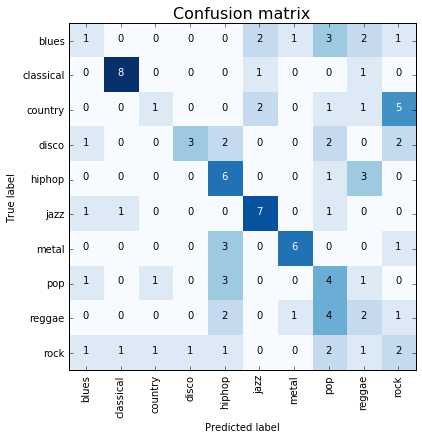

In [50]:
plot_confusion_matrix(classification_results_fused[(("chroma",))], le)

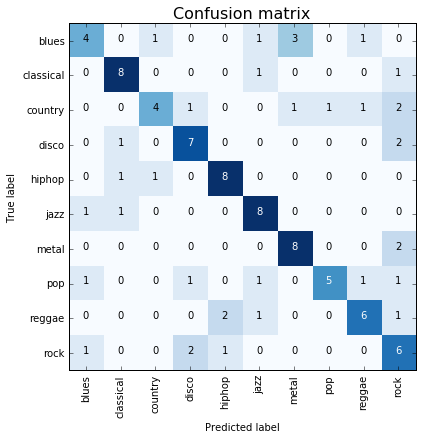

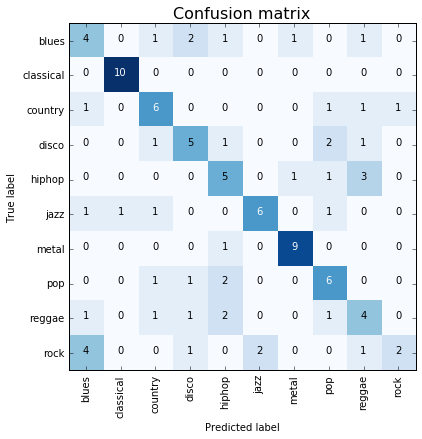

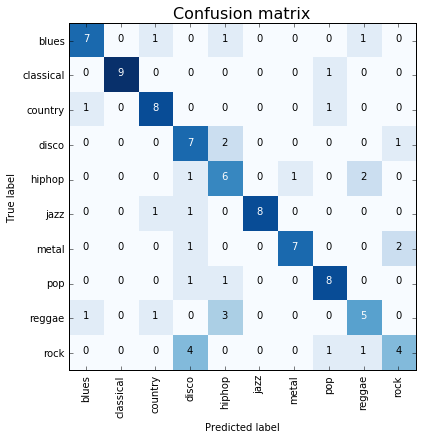

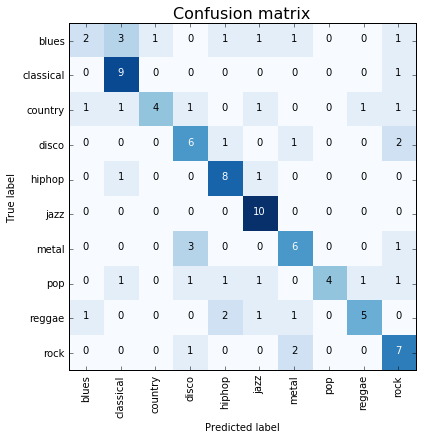

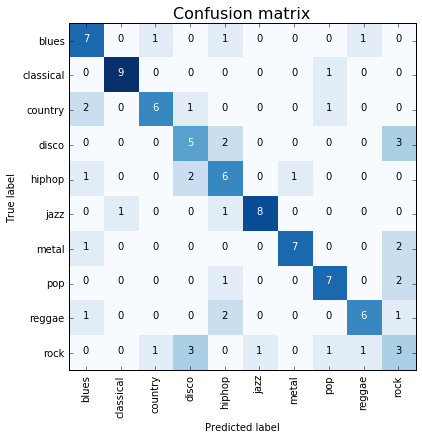

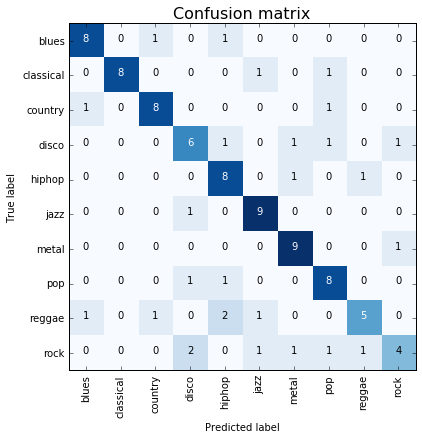

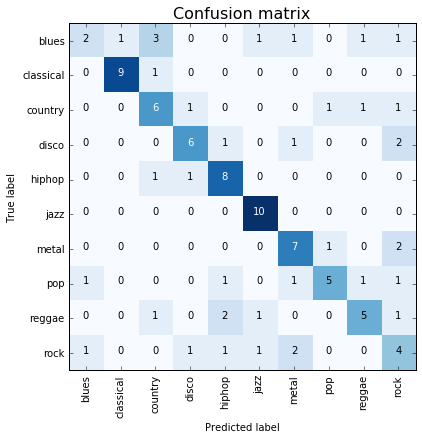

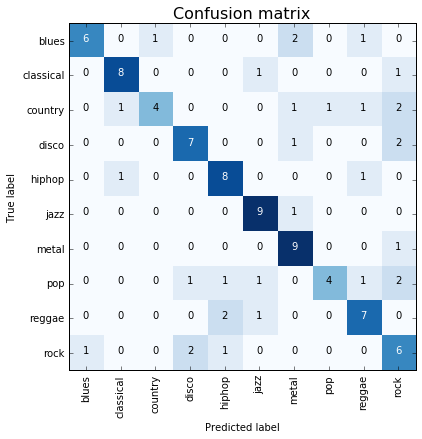

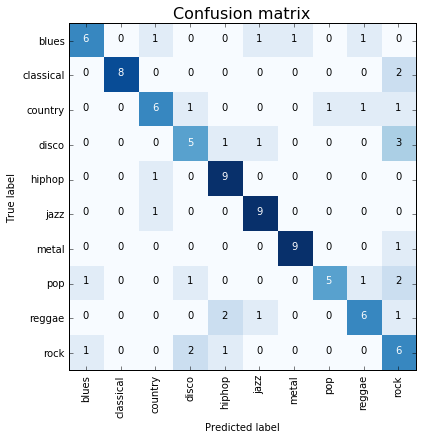

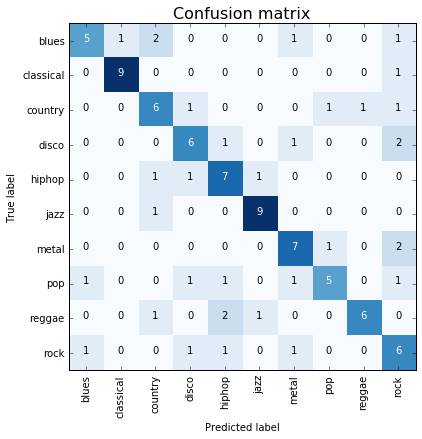

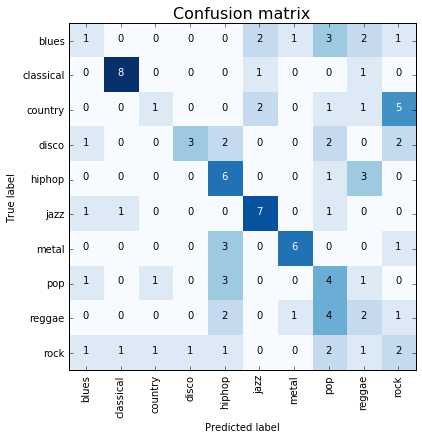

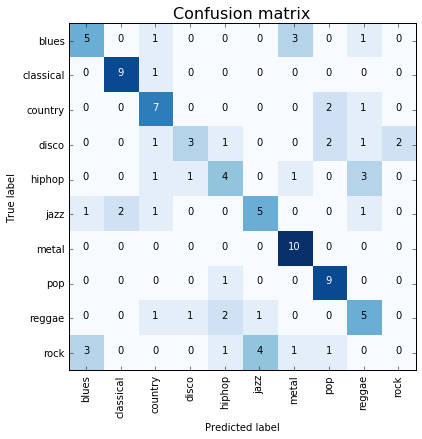

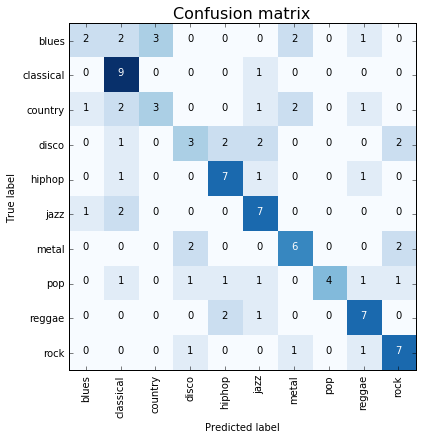

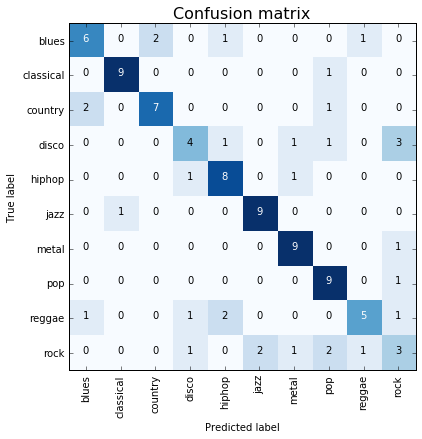

In [27]:
import time
for key in classification_results_fused.keys():
    plot_confusion_matrix(classification_results_fused[key], le)

In [13]:
import pickle
out = open("audio_features.p", "wb")
pickle.dump(audio_features, out)
out.close()

In [14]:
import pickle
audio_features = pickle.load( open( "audio_features.p", "rb" ) )

### Conclusions
The best performing feature-set combinatios are (ssd,mfcc) with accuracy 0.73 and F1-score 0.724, after it follows (ssd,mfcc,chroma) with accuracy of 0.69 and F1-score of 0.695. In top 5 feature-set combintions, ssd is present 5 times, while mfcc is present 3 times. ssd alone performed even better than some feature-set combinations. The worst classification performance have other feature-sets not combined,  mfcc,rp,chroma. So we can conclude that feature-set ssd gives the most information as feature and consequently yields the best results.

We noticed that almost all of the feature-set combinations perform very well on classical music. In the following discussion we will discuss about top 4 feature-set combinations (ssd,mfcc), (ssd,mfcc,chroma), (ssd,mfcc,rp) and (ssd). All of them performed very well on hiphop, jazz, metal and pop classes. While (ssd,mfcc,rp) performed a bit worser than others in pop class.

Classes that are 

# Similarity Retrieval / Query by example

The second part of the assignment focuses on retrieving similar songs to a given example. Content based music similarity can also be defined upon the numeric feature-space. Thus, you will use the extracted music features from the classification experiments, but now you will implement a late fusion approach. The problem with early fusion is that results will skew towards features-sets with higher dimensionality. Late fusion represents a convenient method to overcome this problem by combining the result-spaces instead of the feature-spaces. For each feature first the similarities are calculated separately and then aggregated into a final estimation. Thus, every feature has an equal influence on the final result.

**Normalization**

Just like for the classification experiments the feature-spaces first need to be normalized. 

* iterate over all feature-sets
* use the *StandardScaler* as above, but because there are no train/test-splits, fit the scaler using all instances of a feature-set, and finally perform the transformation
* you can overwrite the extracted *audio_features*; their original values are not required further.

In [15]:
# add your code here
for feature_name in audio_features.keys():
    scaler = StandardScaler()
    audio_features[feature_name] = scaler.fit_transform(
            audio_features[feature_name])

**Implement a query-by-example system:**

* define a *query_id* variable. This represents the index into the feature-space. The feature-vector with the corresponding id will be used to find similar songs.
* define a list of feature-set names. This is equivalent to the feature combinations you have implemented for the classification experiments.
* define a corresponding list of feature-weights. Usually weights scale from 0.0 to 1.0 and represent the influence of a feature-set on the final result.
* for each feature-set of the specified feature-set combination:
  * calculate the Eucledian-distance from the query-feature-vector to every other vector of a feature-set:

$$
\sqrt{\sum (audio\_features[feature\_name] - audio\_features[feature\_name][query\_id])^{2}}
$$

  * this will result in a distance value for each feature-vector representing the dis-similarity to the query-vector.
  * due to variances in dimensionality and value-ranges these distances vary between the feature-sets. To normalize the impact of a distinct feature-set in a late-fusion approach, you have to normalize each resulting distance-list by dividing it by its maximum value.
  * multiply each normalized distance-list with its corresponding feature-weight
  * calculate the sum of the weighted distance-lists
  * finally, use apply numpy function *argsort* on the final results to get the indexes to the feature-vectors ranked by their ascending summed distances. Thus, the top results have the lowest distance/dis-similarity to the query-vector and are expected to sound similar to the query-song.
  * use our provided method to display the retrieval results:
  
        show_query_results(filenames, labels, ranked_index)
      
The displayed result-table contains HTML5 audio player tags. Unfortunately, most Internet browsers have a security-lock to prevent Web-pages from referencing or accessing local files. 

* To enable the playback of the audio-files, open a command-prompt and change to the root directory of the provided dataset (*AUDIO_COLLECTION_PATH*). 
* start the Python simple web-server on port 5555. This will create a simple web-server which handles requests to the local files:

        > python -m SimpleHTTPServer 5555

Alternatively, you can resort to one of the following [http static server one-liners](https://gist.github.com/willurd/5720255).

In [123]:
# add your code here
np.random.seed(1)
query_id = 239
feature_sets = combinations
feature_weights = np.random.rand(len(feature_sets))
feature_distances={}

for index,feature_set in enumerate(feature_sets):
    x = []
    for feature_name in feature_set:
        x.append(audio_features[feature_name])
    X = np.concatenate(x, axis=1)
    query_vec = X[query_id]
    distances = []
    for sample_index in range(len(labels)):
        dist = np.linalg.norm(X[sample_index]-query_vec)
        distances.append(dist)
    normalized = np.array(distances) / np.max(distances,axis=0)
    feature_distances[feature_set] = normalized * feature_weights[index]

summed_distances = []
                   
for sample_index in range(len(labels)):
    dist = 0
    for feature_set in feature_sets:
        dist += feature_distances[feature_set][sample_index]
    summed_distances.append(dist)
ranked_index = np.argsort(summed_distances)
show_query_results(filenames,labels,ranked_index)



rank,index,filename,label,audio
0,239,genres\country\country.00039.au.mp3,country,
1,253,genres\country\country.00053.au.mp3,country,
2,968,genres\rock\rock.00068.au.mp3,rock,
3,686,genres\metal\metal.00086.au.mp3,metal,
4,48,genres\blues\blues.00048.au.mp3,blues,
5,629,genres\metal\metal.00029.au.mp3,metal,
6,988,genres\rock\rock.00088.au.mp3,rock,
7,800,genres\reggae\reggae.00000.au.mp3,reggae,
8,983,genres\rock\rock.00083.au.mp3,rock,
9,643,genres\metal\metal.00043.au.mp3,metal,


* Experiment with different feature-set combinations and feature-weights using different query-songs.
* show two good and two bad performing examples using the *show_query_results* function
* write a paragraph where you summarize the conclusions of the query-by-example experiments
  * which feature-sets are performing best and why?
  * listening to the results, what is the perceived quality?
    * in which terms do the top-ranked results sound similar
    * are there songs that do not fit at all?
    * do they at least share some acoustic similarity with the query-song (e.g. rhythm, instrumentation, pitch, etc.)?
  * compare the query-by-example precision with the classification confusion-matrix for the corresponding feature-set-combination. Are the top confusions also predominant mismatches within the top-ranked retrieval results?

In [178]:
# add your code here
query_id = 225
feature_sets = [('ssd',),
 ('mfcc',),
 ('rp',),
 #('chroma',),
 ('ssd', 'mfcc'),
 ('ssd', 'rp'),
 #('ssd', 'chroma'),
 ('mfcc', 'rp'),
 #('mfcc', 'chroma'),
 #('rp', 'chroma'),
 ('ssd', 'mfcc', 'rp'),
 #('ssd', 'mfcc', 'chroma'),
 #('ssd', 'rp', 'chroma'),
 #('mfcc', 'rp', 'chroma')
]
feature_weights = [0.1,0.1,0.1,0.1,0.1,0.1, 0.1]
feature_distances={}

for index,feature_set in enumerate(feature_sets):
    x = []
    for feature_name in feature_set:
        x.append(audio_features[feature_name])
    X = np.concatenate(x, axis=1)
    query_vec = X[query_id]
    distances = []
    for sample_index in range(len(labels)):
        dist = np.linalg.norm(X[sample_index]-query_vec)
        distances.append(dist)
    normalized = np.array(distances) / np.max(distances,axis=0)
    feature_distances[feature_set] = normalized * feature_weights[index]

summed_distances = []
                   
for sample_index in range(len(labels)):
    dist = 0
    for feature_set in feature_sets:
        dist += feature_distances[feature_set][sample_index]
    summed_distances.append(dist)
ranked_index = np.argsort(summed_distances)
show_query_results(filenames,labels,ranked_index)

rank,index,filename,label,audio
0,225,genres\country\country.00025.au.mp3,country,
1,237,genres\country\country.00037.au.mp3,country,
2,232,genres\country\country.00032.au.mp3,country,
3,264,genres\country\country.00064.au.mp3,country,
4,251,genres\country\country.00051.au.mp3,country,
5,210,genres\country\country.00010.au.mp3,country,
6,226,genres\country\country.00026.au.mp3,country,
7,261,genres\country\country.00061.au.mp3,country,
8,252,genres\country\country.00052.au.mp3,country,
9,228,genres\country\country.00028.au.mp3,country,


### Conclusions

During our experiments, we have found two examples for which no similar samples could be found that belong to the same genre. In particular, those are the samples 239 (country) and 977 (rock). During our search, initially we started from a point where we have used all feature set combinations (weighted equally), and modified the parameters afterwards (that is, involved feature sets and according weights) in order to increase or decrease the quality of retrieval results. 
We found out that, for sample 977, the 'chroma' feature set was particulary of no use, since not only that no similar samples from the same category (rock) were found, but also after listening to the samples we were not convinced that the songs were similar (in best case one could eventually find some rhythm similarities). After involving different feature sets, particulary those that generally showed a better performance (e.g. 'ssd', which is contained in feature sets with the highest F1 scores), additional songs from the same category were found (e.g. feature set ('ssd',), ('ssd', 'mfcc') with weights 0.16 and 0.84). For the bad sample 239, the feature set 'ssd' showed a weak performance. After removing all feature sets that contained the 'ssd' features, results improved. Furthermore, after listening to the retrieved samples, we could very clearly recognize similar rhythm and frequencies amongst found samples. 

For the good sample 129, all query results were of the same genre as the query sample. After listening to the retrieved samples, one could hear that the timbre and the frequencies were very similar. After focusing on combinations containing the 'ssd' feature set, the timbre, rhythm and frequency similarities even further increased. The SSD feature set seems to be very  adequate for finding similarities in classical music, perhaps because of its focus on the 24 critical bands of the sonograph.  For sample 225, good retrieval results were achieved as well. When involoving all feature set combinations and weighing them equally (0.1 each), only one found sample differed in genre, all other belonged to the same genre (equal to the genre of the query sample). After removing combinations involving the 'chroma' feature set, results improved even further and all found samples were of the same genre as the sample query (country). After listening to the retrieved samples, we could recognize that the rhythm, the frequencies and the intensity of the sounds were very similar. 

In summary, one can say that the results found by the query experiments pretty well match the confusion-matrix results. For instance, the 'mfcc' feature set seems to be good for predicting country music, while the 'ssd' feature set seems to be pretty good for predicting classical music. In addition, the 'chroma' feature set seems to be particularly bad for predicting rock music, while the 'ssd' feature set seems to be particularly bad for predicting country music. 
